In [1]:
import sys
import pickle
sys.path.append("../tools/")
import numpy as np
import pandas as pd
from sklearn.preprocessing import Imputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
financial_features= ['salary', 
                     'deferral_payments', 
                     'total_payments', 
                     'loan_advances', 
                     'bonus', 
                     'restricted_stock_deferred', 
                     'deferred_income', 
                     'total_stock_value', 
                     'expenses', 
                     'exercised_stock_options', 
                     'other', 
                     'long_term_incentive', 
                     'restricted_stock', 
                     'director_fees']
email_features=['to_messages', 
                 'email_address', 
                 'from_poi_to_this_person', 
                 'from_messages', 
                 'from_this_person_to_poi', 
                 'shared_receipt_with_poi'] 
 #(units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)
poi_label = ['poi']
features_list = poi_label + email_features + financial_features
#i have removed 'email_address' from features_list as it will only create noise
features_list.remove('email_address')
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)


C:\Users\user\Anaconda3\envs\py2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\user\Anaconda3\envs\py2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
### Task 2: Remove outliers
#total number of data points
print "Total number of data points: " 
print len(data_dict)
#allocation across classes (POI/non-POI)
poi = 0
for name in data_dict:
    if data_dict[name]['poi'] == True:
        poi+=1
print "total number of POI:"
print poi
print "total number of non POI:"
print (len(data_dict)-poi)
#number of features used
print "number of features used:"
print len(features_list)

Total number of data points: 
146
total number of POI:
18
total number of non POI:
128
number of features used:
20


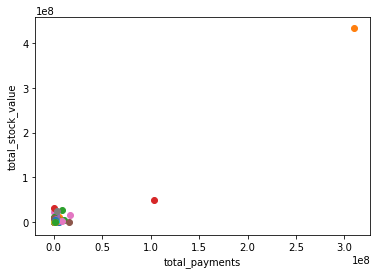

In [3]:
### Task 2: Remove outliers
#Outlier Investigation
#identifies outlier(s) in the financial data, and explains how they are removed or otherwise handled
def plot_outlier(data_dict, feature_1, feature_2):
    
    data = featureFormat(data_dict, [feature_1, feature_2])
    for point in data:
        x = point[0]
        y = point[1]
        plt.scatter(x, y)

    plt.xlabel(feature_1)
    plt.ylabel(feature_2)
    plt.show()

plot_outlier(data_dict, 'total_payments', 'total_stock_value')

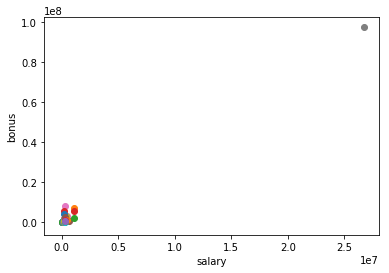

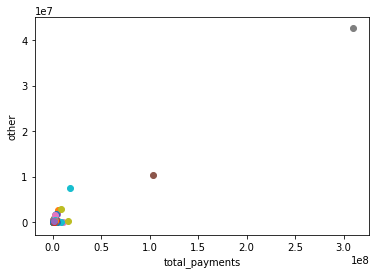

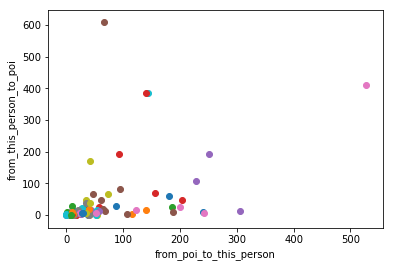

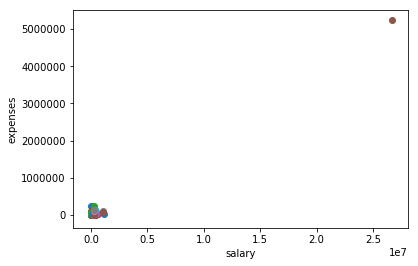

In [104]:
#Outlier Investigation
plot_outlier(data_dict, 'salary', 'bonus')
plot_outlier(data_dict, 'total_payments', 'other')
plot_outlier(data_dict, 'from_poi_to_this_person', 'from_this_person_to_poi')
plot_outlier(data_dict, 'salary', 'expenses')

In [38]:
#indentifing outlier
identiting_outlier = []
for emp in data_dict:
    if data_dict[emp]['total_payments'] != "NaN":
        identiting_outlier.append((emp, data_dict[emp]['total_payments']))
print("Outlier:")
print(sorted(identiting_outlier, key = lambda x: x[1], reverse=True)[0:5])

Outlier:
[('TOTAL', 309886585), ('LAY KENNETH L', 103559793), ('FREVERT MARK A', 17252530), ('BHATNAGAR SANJAY', 15456290), ('LAVORATO JOHN J', 10425757)]


In [7]:
identiting_outlier = []
for emp in data_dict:
    if data_dict[emp]['bonus'] != "NaN":
        identiting_outlier.append((emp, data_dict[emp]['bonus']))
print("Outlier:")
print(sorted(identiting_outlier, key = lambda x: x[1], reverse=True)[0:5])

Outlier:
[('TOTAL', 97343619), ('LAVORATO JOHN J', 8000000), ('LAY KENNETH L', 7000000), ('SKILLING JEFFREY K', 5600000), ('BELDEN TIMOTHY N', 5249999)]


In [3]:
# removing outlier
#TOTAL  is the total value of financial 
print 'TOTAL :'
data_dict.pop( "TOTAL", 0 )



TOTAL :


{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_deferred': -7576788,
 'salary': 26704229,
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 309886585,
 'total_stock_value': 434509511}

In [3]:
#are there features with many missing values?
missing_values = {}
total_features = data_dict[data_dict.keys()[0]].keys()
for feature in total_features:
    missing_values[feature] = 0
for emp in data_dict:
    for feature in data_dict[emp]:
        if data_dict[emp][feature] == "NaN":
            missing_values[feature] += 1
print("total number of missing values for each feature: ")
for feature in missing_values:
    print(feature + " " + str(missing_values[feature]))

total number of missing values for each feature: 
salary 51
to_messages 59
deferral_payments 107
total_payments 21
loan_advances 142
bonus 64
email_address 34
restricted_stock_deferred 128
total_stock_value 20
shared_receipt_with_poi 59
long_term_incentive 80
exercised_stock_options 44
from_messages 59
other 53
from_poi_to_this_person 59
from_this_person_to_poi 59
poi 0
deferred_income 97
expenses 51
restricted_stock 36
director_fees 129


In [4]:
#adding 1st feature ie...fraction_msg_from_poi

for emp in data_dict:
    message_from_poi=data_dict[emp]['from_poi_to_this_person']
    to_message =data_dict[emp]['to_messages']
    if  to_message!='NaN' and message_from_poi!='NaN':
        data_dict[emp]['fraction_msg_from_poi']=(message_from_poi*1.0)/(to_message*1.0)
    else:
        data_dict[emp]['fraction_msg_from_poi']=0
#adding 1st feature ie...fraction_msg_to_poi
for emp in data_dict:
    message_to_poi=data_dict[emp]['from_this_person_to_poi']
    from_message =data_dict[emp]['from_messages']
    if  from_message!='NaN' and message_to_poi!='NaN':
        data_dict[emp]['fraction_msg_to_poi']=(message_to_poi*1.0)/(from_message*1.0)
    else:
        data_dict[emp]['fraction_msg_to_poi']=0
        
updated_features_list=features_list+['fraction_msg_to_poi']+['fraction_msg_from_poi']
print updated_features_list

['poi', 'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi', 'salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees', 'fraction_msg_to_poi', 'fraction_msg_from_poi']


In [5]:
# fill NaN values with zeros
for emp in data_dict:
    for f in data_dict[emp]:
        if data_dict[emp][f] == 'NaN':
            
            data_dict[emp][f] = 0

my_dataset = data_dict

In [6]:
### Extract features and labels from dataset for local testing
my_dataset = data_dict
data = featureFormat(my_dataset,updated_features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [7]:
# we want to remove all features that are either one or zero (on or off) in more than 80% of the 
# samples using VarianceThreshold
from sklearn.feature_selection import VarianceThreshold
var = VarianceThreshold(threshold=(.8 * (1 - .8)))
features = var.fit_transform(features)

In [8]:
# intelligently select features (univariate feature selection)
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k = 8)
selector.fit(features, labels)
scores = zip(updated_features_list[1:], selector.scores_)
scores_sorted= sorted(scores, key = lambda x: x[1], reverse = True)
print 'SelectKBest scores features:'
print scores_sorted

SelectKBest scores features:
[('exercised_stock_options', 25.097541528735491), ('total_stock_value', 24.467654047526398), ('bonus', 21.060001707536571), ('salary', 18.575703268041785), ('deferred_income', 11.595547659730601), ('long_term_incentive', 10.072454529369441), ('restricted_stock', 9.3467007910514877), ('total_payments', 8.8667215371077717), ('shared_receipt_with_poi', 8.7464855321290802), ('loan_advances', 7.2427303965360181), ('expenses', 6.2342011405067401), ('from_poi_to_this_person', 5.3449415231473374), ('other', 4.204970858301416), ('from_this_person_to_poi', 2.4265081272428781), ('director_fees', 2.1076559432760908), ('to_messages', 1.6988243485808501), ('deferral_payments', 0.2170589303395084), ('from_messages', 0.16416449823428736), ('restricted_stock_deferred', 0.06498431172371151)]


In [9]:
revised_features_list = poi_label + [(i[0]) for i in scores_sorted[0:8]]
print 'Revised features list'
print revised_features_list

Revised features list
['poi', 'exercised_stock_options', 'total_stock_value', 'bonus', 'salary', 'deferred_income', 'long_term_incentive', 'restricted_stock', 'total_payments']


In [10]:

from sklearn import preprocessing
data = featureFormat(my_dataset, revised_features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)

In [11]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = \
cross_validation.train_test_split(features, labels, test_size=0.3, random_state=42)

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
# # Provided to give you a starting point. Try a variety of classifiers.

from sklearn.naive_bayes import GaussianNB
from time import time
clf_nb = GaussianNB()
clf_nb.fit(features_train,labels_train)
pred = clf_nb.predict(features_test)
nb_score = clf_nb.score(features_test,labels_test)
nb_acc = accuracy_score(labels_test,pred)
nb_pre = precision_score(labels_test,pred)
nb_rec = recall_score(labels_test,pred)
print "NB accuracy:"
print nb_acc
print "NB precision:"
print nb_pre
print "NB recall:"
print nb_rec


NB accuracy:
0.863636363636
NB precision:
0.4
NB recall:
0.4


In [11]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=10)
rf_clf.fit(features_train, labels_train)
pred = rf_clf.predict(features_test)
rf_score = rf_clf.score(features_test,labels_test)
rf_acc = accuracy_score(labels_test,pred)
rf_pre = precision_score(labels_test,pred)
rf_rec = recall_score(labels_test,pred)
print "RF accuracy: "
print rf_acc
print "RF precision: "
print rf_pre
print "RF recall: "
print rf_rec

RF accuracy: 
0.840909090909
RF precision: 
0.25
RF recall: 
0.2


In [12]:
from sklearn import grid_search
from sklearn import tree
dt= tree.DecisionTreeClassifier()
Decision_Tree_parameters = {'criterion':('gini','entropy'),
'splitter':('best','random')}
dt_clf = grid_search.GridSearchCV(dt,Decision_Tree_parameters)
dt_clf.fit(features_train, labels_train)
pred = dt_clf.predict(features_test)
dt_score = dt_clf.score(features_test, labels_test)

dt_acc = accuracy_score(labels_test, pred)
dt_pre = precision_score(labels_test, pred)
dt_rec = recall_score(labels_test, pred)
print "DT accuracy: "
print dt_acc
print "DT precision: "
print dt_pre
print "DT recall:"
print dt_rec

DT accuracy: 
0.75
DT precision: 
0.2
DT recall:
0.4


In [18]:
from sklearn import grid_search
from sklearn import svm
svr = svm.SVC()
svm_parameters = {'kernel':('linear','rbf','sigmoid'),
'gamma': [1,0.1,0.01,],
'C': [0.1,1,10,100,1000]}
svr_clf = grid_search.GridSearchCV(svr, svm_parameters)
svr_clf.fit(features_train, labels_train)
pred = svr_clf.predict(features_test)
svr_score = svr_clf.score(features_test, labels_test)
svr_acc = accuracy_score(labels_test, pred)
svr_pre = precision_score(labels_test, pred)
svr_rec = recall_score(labels_test, pred)
print "svm accuracy:", 
print svr_acc
print "svm precision:", 
print svr_pre
print "svm recall:", 
print svr_rec

svm accuracy: 0.886363636364
svm precision: 0.5
svm recall: 0.2


In [15]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)
    
    
from sklearn import naive_bayes
clf = naive_bayes.GaussianNB()
features_list = revised_features_list 

In [16]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)